# CISC-839 Data Analytics Project

## A Session Based - Recommendation System

This Sysyem is a session-based recommendation system, powered by the Ternec dataset. Leveraging the [Tenrec: A Large-scale Multipurpose Benchmark Dataset for Recommender Systems](https://proceedings.neurips.cc/paper_files/paper/2022/file/4ad4fc1528374422dd7a69dea9e72948-Paper-Datasets_and_Benchmarks.pdf) Paper, we aim to deliver personalized recommendations that adapt to users' session-specific preferences in real-time. Join us as we revolutionize the way users discover content by harnessing the power of session-based modeling and the rich insights provided by the Ternec dataset.

## Team Members
- Adham Mokhtar
- Manar El-Ghobashy
- Yara Mohammed
- Yara El-Zahy

## Recommended Pipline
- Data Acquisition: Obtain the Ternec dataset, ensuring it contains the necessary session-based information, such as user interactions, session context, and item properties.

- Data Preprocessing: Clean the dataset by removing duplicate or irrelevant entries, handling missing values, and normalizing or transforming features as required. Split the dataset into training, validation, and test sets.

- Session Representation: Convert the session-based data into a suitable representation, such as sequences or graphs, to capture the temporal dynamics and dependencies between user actions.

- Feature Engineering: Extract relevant features from the dataset, such as item attributes, timestamps, or session context, to enhance the recommendation model's understanding of user preferences.

- Model Selection: Explore various session-based recommendation models, such as Recurrent Neural Networks (RNNs), Transformer-based models, or Graph Neural Networks (GNNs), considering their ability to capture temporal patterns and handle session-based data.

- Model Training: Train the selected model using the training dataset and optimize its hyperparameters using the validation set. Apply appropriate loss functions, regularization techniques, and optimization algorithms to enhance the model's performance.

- Model Evaluation: Evaluate the trained model on the test dataset using suitable evaluation metrics like precision, recall, or Mean Average Precision (MAP). Analyze the model's performance to gain insights into its strengths and weaknesses.

- Hyperparameter Tuning: Fine-tune the model's hyperparameters using techniques like grid search or random search to further optimize its performance. Validate the tuned model using the validation set.

- Performance Analysis: Conduct an in-depth analysis of the recommendation results, considering factors like recommendation diversity, novelty, and coverage. Incorporate user feedback and iterate on the model or pipeline as necessary.

- Deployment: Once satisfied with the model's performance, deploy it in a production environment to generate real-time recommendations. Implement mechanisms to handle new user sessions, adapt to changing user preferences, and ensure scalability and efficiency.

- Monitoring and Maintenance: Continuously monitor the recommendation system's performance, gather user feedback, and update the model periodically to reflect evolving user preferences and market trends.

## Import Libraries

In [2]:
# general
import csv
import numpy as np
import pandas as pd

# torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# tensorflow/keras
import tensorflow as tf
from keras_preprocessing.sequence import pad_sequences

# sklearn
from sklearn.preprocessing import LabelEncoder

# transformers
from transformers import BertTokenizer, BertForSequenceClassification

# graphs
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt

%matplotlib inline

## Useful/Common Methods

In [2]:
def display_value_counts_bar(df, cols_per_row, total_size):
    nrows = int(np.ceil(len(df.columns)/cols_per_row))
    _, axes = plt.subplots(nrows=nrows, ncols=cols_per_row, figsize=(20, 20))
    row_index = 0
    column_index = 0
    count = 0
    for column in df.columns:
        if count < total_size:
            if nrows > 1:
                ax = axes[row_index, column_index]
            else:
                ax = axes[row_index]
            ax.set_title(column)
            ax.tick_params(axis='x', labelrotation = 90)

            top_counts = df[column].value_counts().sort_values(ascending=False).head(10)
            top_counts.plot.bar(ax=ax)

            column_index += 1
            if column_index % cols_per_row == 0:
                row_index += 1
                column_index = 0
            count += 1

    plt.tight_layout()
    plt.show()

## Data Acquisition
Data is already there but once it is a huge data (exactly 14.7 GB) near to a half billion record (exactly 493,458,971 record), we will use like a 10% of the data on preprocessing, EDA, models training and models evaluation.

So, we will create a new file with this percentage first.

The four datasets used in this paper are raw datasets:
- `QK-video.csv`
- `QK-article.csv`
- `QB-video.csv`
- `QB-article.csv`

All task-specific datasets are extracted from these datasets. 

Subdataset:

1. `ctr_data_1M.csv` is used in CTR task (Section 3.1) and Multi-Task Learning  (Section 3.3).

2. `cold_data.csv` (Table 7, Section 3.6), `cold_data_1.csv`, `cold_data_0.3.csv`, `cold_data_0.7.csv` are used for the Cold-Start task (see Appendix Table 5).

3. `task_0.csv`, `task_1.csv`, `task_2.csv`, `task_3.csv` are used in Lifelong Learning (see Section 3.7, Table 8). 

4. `sbr_data_1M.csv` is used in Session-based Recommendation (Section 3.2), Transfer Learning (Section 3.4, used as pre-training dataset), User Profile Prediction (Section 3.5), Model Compression (Section 3.8), Model Training Speedup (Section 3.9).

Note that: 

1. Model Inference Speedup Task (Section 3.10): the dataset is `QB-video.csv`, and Transfer Learning Task (Section 3.4): target dataset is also `QB-video.csv`.

2. We sort the items at the user level in order of click time, so the time information is implicit in the order of the items.

Example: 
| userid | itemid |
| ---    | ---    |
| 2345   | 12     |
| 2345   | 5      |
| 2345   | 61     |
| 2345   | 78     |
| 2345   | 35     |

The click sequence of user 2345 is [12, 5, 61, 78, 35].


In [7]:
data = pd.read_csv('Tenrec/sbr_data_1M.csv')

C:\Users\adham\AppData\Local\Temp\ipykernel_3968\1181029089.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('Tenrec/sbr_data_1M.csv')


In [8]:
data.head()

,user_id,item_id,click,follow,like,share,video_category,watching_times,gender,age
0,1,1,1,0,0,0,1,1,1,4
1,1,2,1,0,0,0,1,1,1,4
2,1,3,1,0,0,0,0,1,1,4
3,1,80936,1,0,0,0,1,1,1,4
4,1,781,1,0,0,0,1,1,1,4


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38300254 entries, 0 to 38300253
Data columns (total 10 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   user_id         int64 
 1   item_id         int64 
 2   click           int64 
 3   follow          int64 
 4   like            int64 
 5   share           int64 
 6   video_category  object
 7   watching_times  int64 
 8   gender          int64 
 9   age             int64 
dtypes: int64(9), object(1)
memory usage: 2.9+ GB


## Data Preprocessing

Steps for Session-Based Recommendation:

- Duplicate Removal: Identify and remove any duplicate entries in the dataset to ensure data integrity and prevent bias in the recommendation process.

- Irrelevant Entry Removal: Eliminate entries that are irrelevant to session-based recommendations, such as non-session interactions or incomplete data.

- Missing Value Handling: Address missing values in the dataset, either by imputing them using appropriate techniques (e.g., mean imputation, regression imputation) or removing instances with missing values, depending on the impact on the overall dataset quality.

- Session Length Filtering: Filter out sessions with insufficient data, ensuring an adequate number of interactions within each session to capture meaningful patterns.

- Session Sorting: Sort the dataset by session and timestamp to establish the temporal order of user interactions within sessions.

- Session Padding: Pad sessions with zero or placeholder values to ensure uniform length, allowing the model to handle sessions of varying lengths efficiently.

- Encoding Categorical Features: Encode categorical features, such as item IDs or session context, into numerical representations suitable for model training (e.g., one-hot encoding, label encoding).

- Normalization or Scaling: Normalize or scale numerical features, such as timestamps or session durations, to a common range to prevent any undue influence on the recommendation model.

- Train-Test Split: Split the preprocessed dataset into training and testing sets, ensuring a representative distribution of sessions and interactions in each.

- Validation Set Creation: Further split the training set into a smaller validation set, which can be used for hyperparameter tuning and model evaluation during the training process.



In [10]:
data.duplicated().sum()

26455

In [11]:
data.isnull().sum()

user_id           0
item_id           0
click             0
follow            0
like              0
share             0
video_category    0
watching_times    0
gender            0
age               0
dtype: int64

<Axes: >

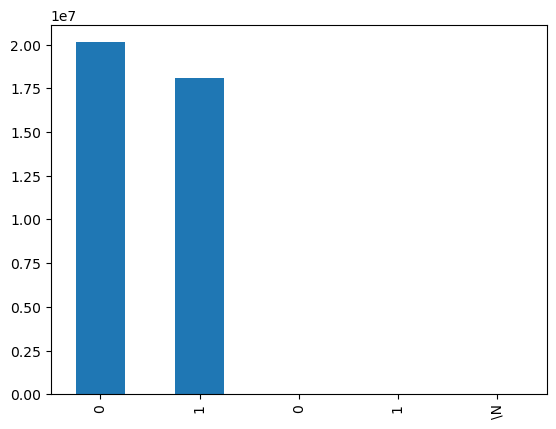

In [12]:
data['video_category'].value_counts().plot.bar()

In [13]:
# drop `\N` records in video_category
data = data[data['video_category'] != "\\N"]
data['video_category'] = data['video_category'].astype('int')

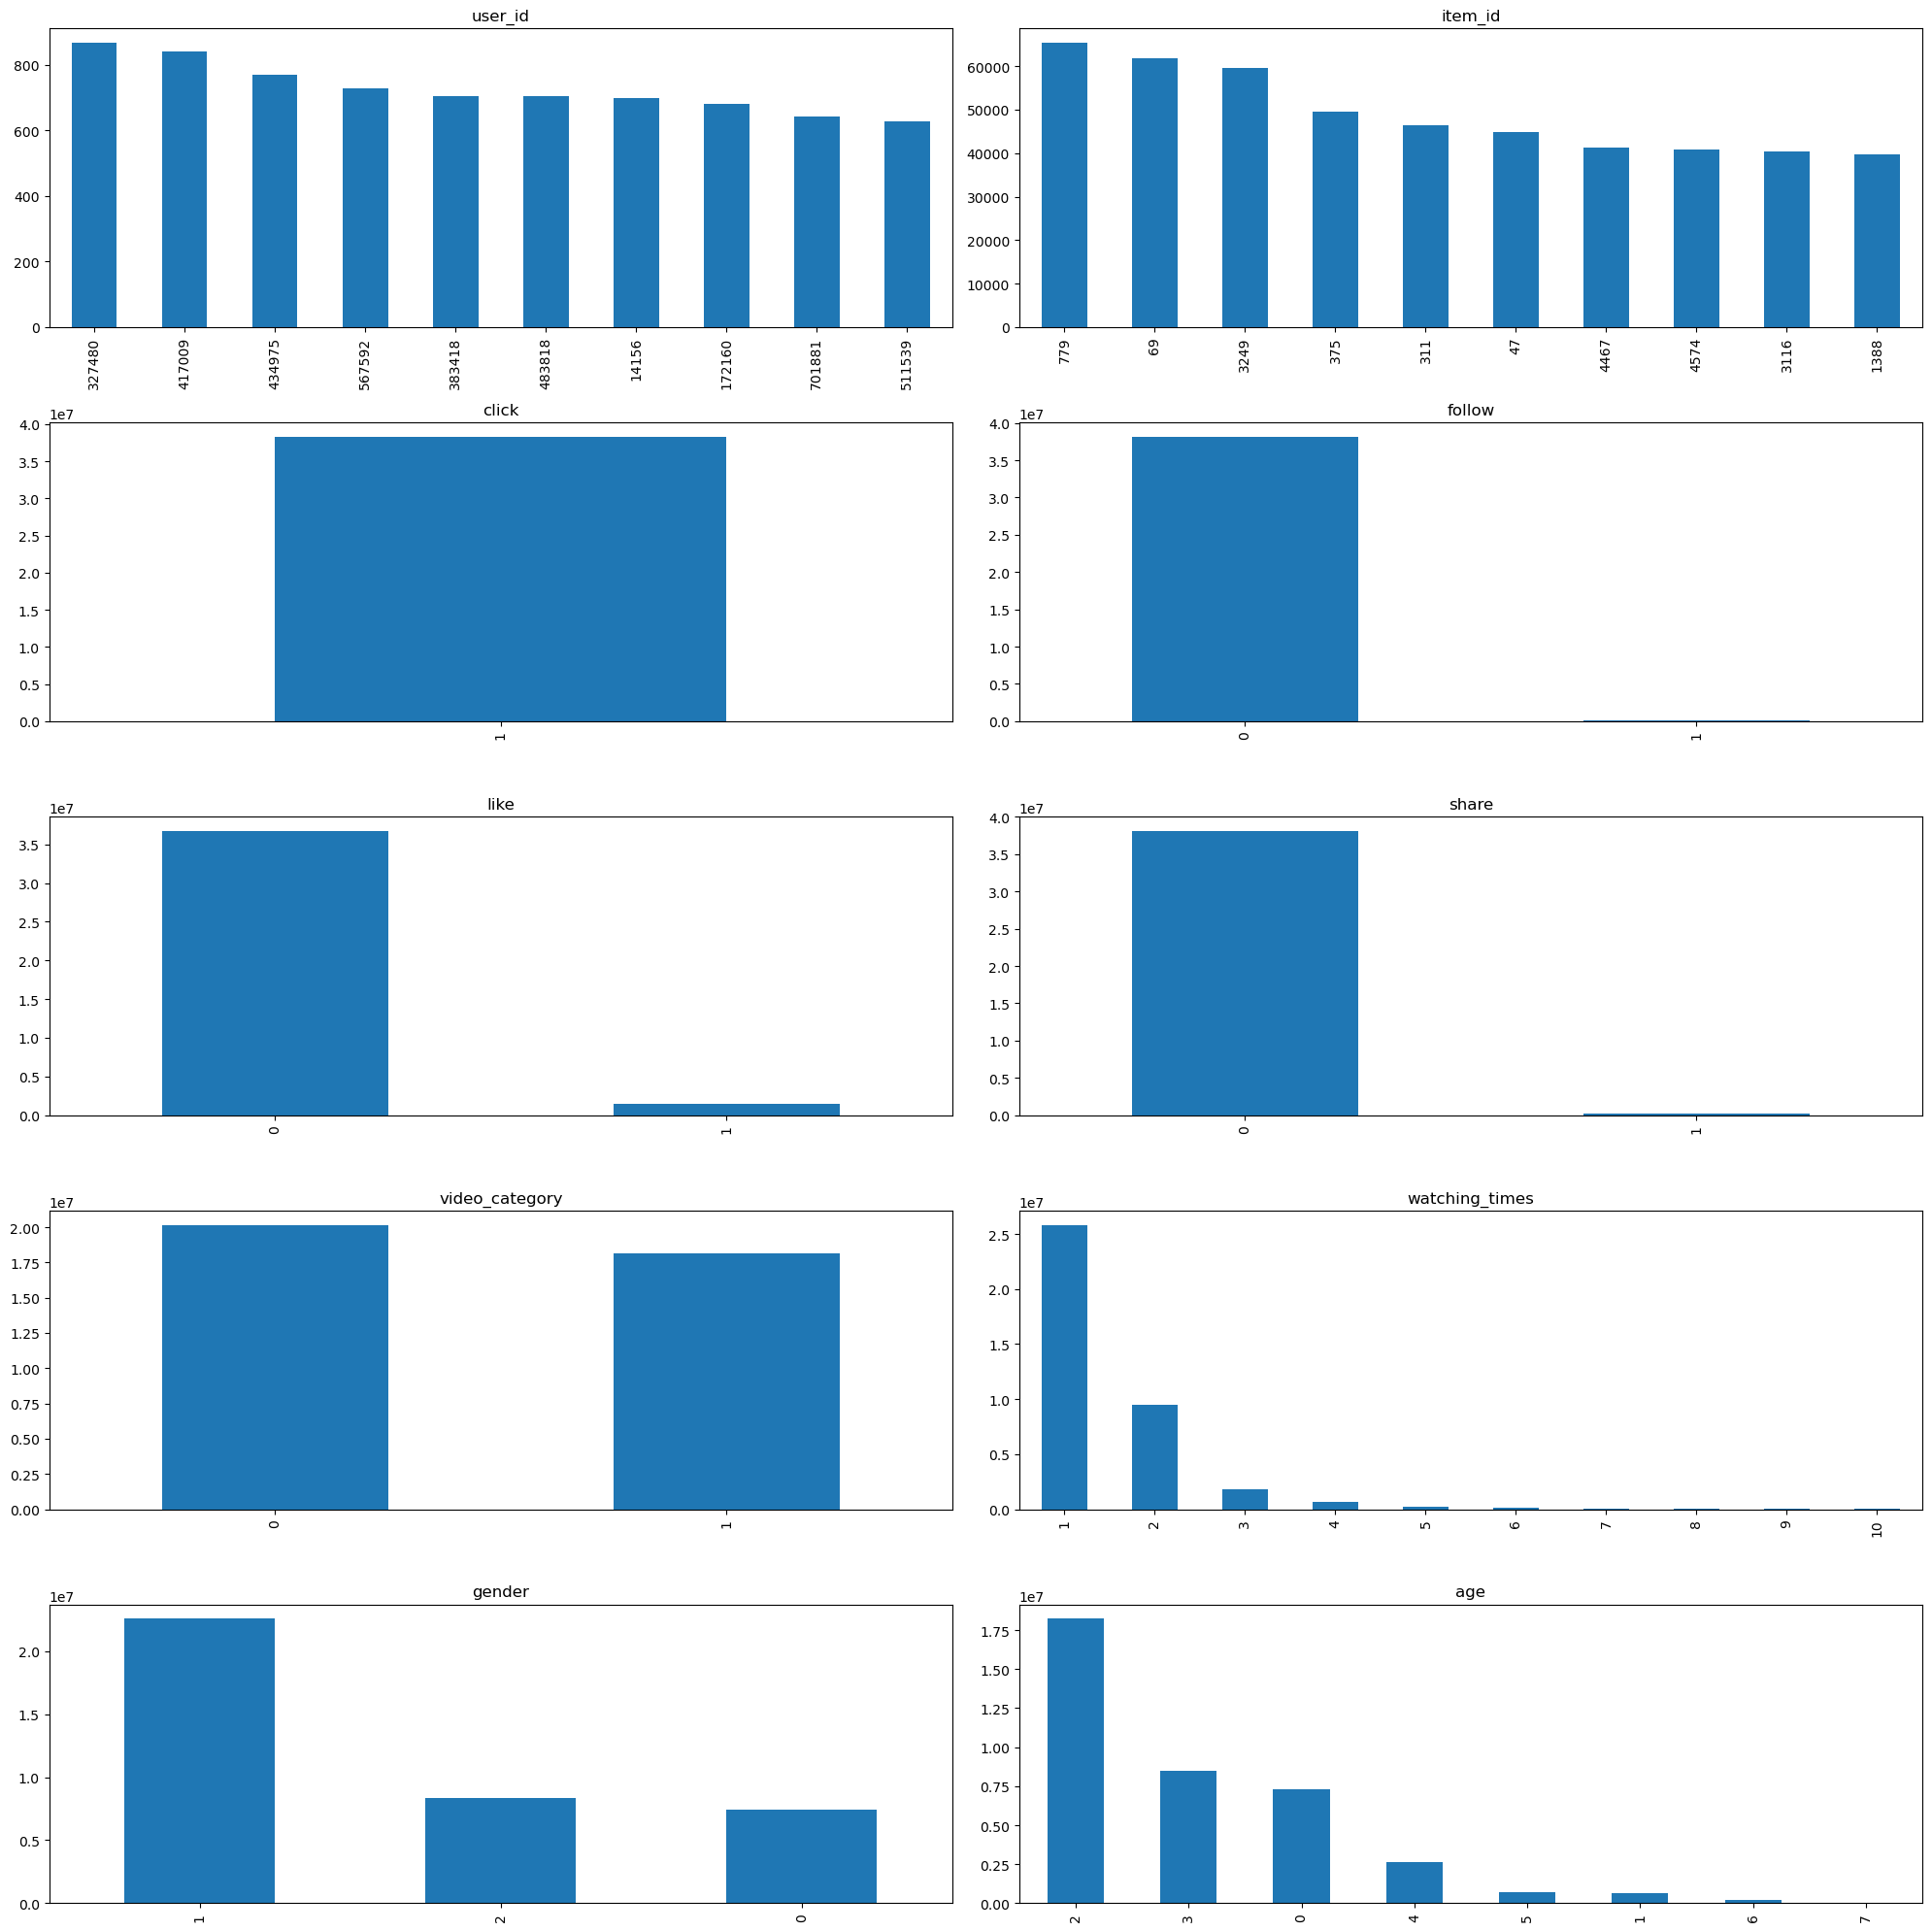

In [14]:
display_value_counts_bar(data, 2, len(data.columns))

### Recommended Steps
here we don't have `interaction_order`

The `'interaction_order'` represents the order of interactions within a session. It assigns a numerical value to each interaction, indicating the position or sequence of the interaction within the session. This feature helps capture the temporal ordering of user interactions and can be useful for modeling sequential patterns in session-based recommendation systems.

To extract or create the `'interaction_order'` feature from the given data, you can follow these steps:

Sort the dataset by session ID and another relevant attribute (e.g., timestamp) to establish the temporal order of interactions within each session.

`df.sort_values(by=['session_id', 'timestamp'], inplace=True)`
Group the dataset by session ID and assign a unique interaction order value to each interaction within the session.

`df['interaction_order'] = df.groupby('session_id').cumcount()`
The cumcount() function generates a sequential count of each interaction within the session, starting from 0. It effectively assigns a unique numerical value to each interaction within a session based on their order.

After executing these steps, you will have the 'interaction_order' feature added to the dataset, representing the order of interactions within each session.

Please note that the 'interaction_order' values are assigned based on the temporal order of interactions within sessions. It is assumed that the interactions within each session have a meaningful ordering, such as the chronological sequence of user actions or the order of items presented to the user. If there is no explicit ordering information available, you may consider alternative methods, such as using relative timestamps or inferring order based on other session attributes or item properties.

Adjust the code based on the specific column names and dataset structure in your case.

In [ ]:
# Load the dataset
df = data.copy()

# Duplicate Removal
df = df.drop_duplicates()

# Irrelevant Entry Removal (if applicable)
# Assuming non-session interactions and incomplete data are irrelevant, drop those rows
df = df.dropna()

# Missing Value Handling (if applicable)
# Assuming missing values are not present in the dataset

# Session Length Filtering
session_lengths = df.groupby('user_id')['item_id'].transform('count')
df = df[session_lengths >= min_session_length]

# Session Sorting based on user interactions' order
df = df.groupby('user_id').apply(lambda x: x.sort_values('interaction_order')).reset_index(drop=True)

# Session Padding (assuming maximum session length is known)
max_session_length = 20  # Example: maximum session length of 20
df = df.groupby('user_id').head(max_session_length).reset_index(drop=True)

# Encoding Categorical Features
df_encoded = pd.get_dummies(df, columns=['gender', 'age'])

# Normalization or Scaling (if applicable)
# Assuming no normalization or scaling is required for the current dataset

# Train-Test Split
train_ratio = 0.8  # Example: 80% training data, 20% testing data
train_size = int(train_ratio * len(df_encoded))
train_data = df_encoded[:train_size]
test_data = df_encoded[train_size:]

# Validation Set Creation (if necessary)
val_ratio = 0.2  # Example: 20% of the training data for validation
val_size = int(val_ratio * len(train_data))
train_data = train_data[:-val_size]
val_data = train_data[-val_size:]

# Print the preprocessed data
print("Preprocessed Training Data:")
print(train_data.head())
print("\nPreprocessed Validation Data:")
print(val_data.head())
print("\nPreprocessed Testing Data:")
print(test_data.head())

Without a timestamp or explicit interaction order column in the dataset, it becomes challenging to establish the precise temporal order of user interactions within sessions. In such cases, you might consider alternative approaches or make assumptions based on the available information. Some possible options include:

Random Order: Assume a random order of interactions within each session. This approach does not consider the temporal aspect explicitly but can still capture patterns within sessions.

Sequential Interaction: If the dataset preserves the order of entries, you can assume that interactions occur sequentially within a session. In this case, you can skip the session sorting step and move directly to session padding.

Session Length: If the dataset provides session length information, you can use it to sort sessions by length, with longer sessions appearing first. This approach assumes that longer sessions are more likely to contain more recent interactions.

Remember, these approaches might not capture the precise temporal dynamics of user behavior within sessions. However, they can still provide valuable insights and patterns that can be leveraged by the recommendation models.

If you have access to additional information or if there are any specific patterns or rules related to session ordering, consider incorporating them into the preprocessing steps to improve the session representation for recommendation purposes.

### Steps

In [15]:
# todo

## Session Representation

Steps for Session-Based Recommendation:

- Sequence Construction: Convert the session-based data into sequences of user interactions, where each session is represented as a sequence of item IDs or other relevant features.

- Sequence Padding: Pad the sequences with zero or placeholder values to ensure uniform length, allowing the model to handle sequences of varying lengths efficiently.

- Embedding Creation: Generate item embeddings or feature embeddings using techniques like word embeddings (e.g., Word2Vec, GloVe) or pre-trained embeddings (e.g., BERT, ELMo). These embeddings capture the semantic relationships between items or features, enabling the model to learn meaningful representations.

- Temporal Ordering: Preserve the temporal ordering of user interactions within each session by maintaining the order of items or features in the sequences.

- Session Context Incorporation: Include relevant session context features, such as timestamps, user demographics, or contextual information, into the session representation to capture the contextual influences on user preferences.

- Graph Construction (Optional): If applicable, represent sessions as graphs, where items or features are nodes and the relationships between them (e.g., co-occurrence, similarity) are edges. Graph-based representations can capture complex dependencies and interactions between items within sessions.

- Graph Embedding (Optional): Generate graph embeddings using graph neural network techniques, such as GraphSAGE, GCN, or GAT. These embeddings capture the structural information of the session graph, enhancing the model's understanding of item relationships.

- Vectorization: Transform the session representations, whether in the form of sequences or graphs, into numerical vectors that can be fed into the recommendation model. This step ensures compatibility between the session representation and the chosen model architecture.

### Steps

In [ ]:
# Load the dataset
df = data.copy()

# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# Sequence Construction
sessions = df.groupby('user_id')['item_id'].apply(list).tolist()

# OR>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

# Sequence Construction with Interaction Order
sessions = df.groupby('user_id').apply(lambda x: x.sort_values('interaction_order')['item_id'].tolist()).tolist()
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

# Sequence Padding
max_sequence_length = 20  # Example: maximum sequence length of 20
padded_sessions = pad_sequences(sessions, maxlen=max_sequence_length, padding='post', truncating='post')

# Embedding Creation (using dummy embeddings as an example)
embedding_dim = 100  # Example: embedding dimension of 100
embedding_matrix = np.zeros((len(df['item_id'].unique()) + 1, embedding_dim))  # +1 for padding/placeholder item
item_embeddings = np.random.randn(len(df['item_id'].unique()), embedding_dim)
embedding_matrix[1:] = item_embeddings

# Temporal Ordering (already preserved by session construction)

# Session Context Incorporation (assuming 'timestamp' column is available)
timestamps = df.groupby('user_id')['timestamp'].apply(list).tolist()

# Graph Construction (optional, not implemented in this example)

# Graph Embedding (optional, not implemented in this example)

# Vectorization (combining session representations and context)
context_features = np.array(timestamps)  # example: using timestamp as context feature
session_representation = np.concatenate((padded_sessions, context_features[:, np.newaxis]), axis=1)

# Print the session representations
print("Session Representations:")
print(session_representation)

In [16]:
# todo

## Feature Engineering

Steps for Session-Based Recommendation:

- Item Features Extraction: Extract relevant item-level features from the Ternec dataset, such as item metadata, genres, descriptions, or user ratings. These features can provide additional context and information about the items in the sessions.

- Session-Level Features Extraction: Derive session-level features from the session data, such as session duration, number of interactions, or average item popularity within a session. These features can capture session-level characteristics that may influence user preferences.

- Time-Based Features: Extract time-based features from timestamps, such as the hour of the day, day of the week, or seasonal patterns. These features can capture temporal dynamics and time-dependent preferences.

- User Features: Incorporate user-related features, such as demographic information, historical preferences, or user clustering labels, to capture individual user preferences and personalize recommendations.

- Item Popularity: Compute item popularity metrics, such as the number of times an item was interacted with or its average rating, to reflect the overall popularity and relevance of items. These metrics can be useful for diversifying recommendations or incorporating popularity biases.

- Similarity Features: Compute similarity measures between items, such as cosine similarity or Jaccard similarity, based on item attributes or user-item interactions. These similarity features can capture item relationships and help recommend similar items.

- Contextual Features: Incorporate contextual features specific to the session, such as the device used, location, or referring source. These features can provide additional insights into the user's context and preferences.

- Interaction History Features: Create features based on the user's interaction history, such as the user's most recent or frequent interactions. These features can capture user preferences and sequential patterns within sessions.

- Feature Encoding: Encode categorical features into numerical representations suitable for model training, using techniques like one-hot encoding, label encoding, or entity embeddings.

- Feature Scaling: Normalize or scale numerical features to a common range to prevent any undue influence on the recommendation model.

### Steps

In [ ]:
# Load the dataset
df = data.copy()

# Item Features Extraction (example: item metadata)
item_metadata = pd.read_csv('item_metadata.csv')
df = pd.merge(df, item_metadata, on='item_id', how='left')

# Session-Level Features Extraction
session_features = df.groupby('user_id')['item_id'].agg({'session_duration': 'count', 'unique_items': 'nunique'})
df = pd.merge(df, session_features, on='user_id', how='left')

# Interaction Order Encoding
df['interaction_order'] = LabelEncoder().fit_transform(df['interaction_order'])

# User Features (example: user demographic information)
user_demographics = pd.read_csv('user_demographics.csv')
df = pd.merge(df, user_demographics, on='user_id', how='left')

# Item Popularity (example: number of interactions per item)
item_popularity = df.groupby('item_id')['interaction'].count().reset_index().rename(columns={'interaction': 'item_popularity'})
df = pd.merge(df, item_popularity, on='item_id', how='left')

# Similarity Features (example: item cosine similarity)
item_similarity = pd.read_csv('item_similarity.csv')
df = pd.merge(df, item_similarity, on='item_id', how='left')

# Contextual Features (example: device used)
contextual_features = pd.read_csv('contextual_features.csv')
df = pd.merge(df, contextual_features, on='session_id', how='left')

# Sequence Construction (session-based sequences)
sessions = df.groupby('session_id')['item_id'].apply(list).reset_index(name='sequence')

# Print the modified dataset with session representation
print("Modified Dataset with Session Representation:")
print(sessions.head())

In [17]:
# todo

## Model Selection

Steps for Session-Based Recommendation:

- Research and Understanding: Familiarize yourself with the characteristics, strengths, and limitations of each model considered for session-based recommendation, namely BERT4Rec, GRU4Rec, SASRec, and NextItNet. Gain insights into their architectures, training approaches, and performance on similar tasks.

- Evaluation Metrics: Determine the evaluation metrics that align with your project goals, such as precision, recall, Mean Average Precision (MAP), or Normalized Discounted Cumulative Gain (NDCG). Ensure that the selected models can be evaluated using these metrics.

- Implementation Suitability: Assess the feasibility and compatibility of each model with the Ternec dataset, session-based recommendation task, and available computational resources. Consider factors such as model complexity, scalability, and ease of implementation.

- Model Performance Comparison: Implement and train each model separately using the Ternec dataset. Evaluate their performance on the chosen evaluation metrics using appropriate validation or test sets. Compare their results to identify the model(s) that demonstrate superior performance.

- Consideration of Specific Requirements: Consider any specific requirements or constraints of your session-based recommendation project. For example, if interpretability is crucial, assess which model provides more explainable recommendations. Take into account factors like model complexity, training time, or memory requirements.

- Robustness and Generalization: Analyze the robustness and generalization capabilities of each model by assessing their performance across different subsets or splits of the Ternec dataset. Consider their ability to handle various session lengths, data sparsity, or different user behavior patterns.

- Expert Advice: Consult with experts or researchers in the field of session-based recommendation or deep learning to gather additional insights and recommendations on model selection. Consider their expertise and experiences to inform your decision-making process.

- Final Model Selection: Based on the performance comparison, compatibility, requirements, and expert advice, select the model(s) that best meet your project goals, dataset characteristics, and implementation constraints. Ensure that the selected models align with the objectives and resources available for your session-based recommendation project.

In [ ]:
# Define the BERT model
class BERT4Rec(nn.Module):
    def __init__(self):
        super(BERT4Rec, self).__init__()
        # Define the architecture of the BERT model
        ...
    
    def forward(self, input_ids):
        # Define the forward pass of the BERT model
        ...
        return output

# Define the NextItNet model
class NextItNet(nn.Module):
    def __init__(self):
        super(NextItNet, self).__init__()
        # Define the architecture of the NextItNet model
        ...
    
    def forward(self, input_ids):
        # Define the forward pass of the NextItNet model
        ...
        return output

# Define the SASRec model
class SASRec(nn.Module):
    def __init__(self):
        super(SASRec, self).__init__()
        # Define the architecture of the SASRec model
        ...
    
    def forward(self, input_ids):
        # Define the forward pass of the SASRec model
        ...
        return output

# Define the GRU4Rec model
class GRU4Rec(nn.Module):
    def __init__(self):
        super(GRU4Rec, self).__init__()
        # Define the architecture of the GRU4Rec model
        ...
    
    def forward(self, input_ids):
        # Define the forward pass of the GRU4Rec model
        ...
        return output

# Instantiate the BERT4Rec model
bert_model = BERT4Rec()
bert_model.to(device)

# Instantiate the NextItNet model
nextit_model = NextItNet()
nextit_model.to(device)

# Instantiate the SASRec model
sasrec_model = SASRec()
sasrec_model.to(device)

# Instantiate the GRU4Rec model
gru4rec_model = GRU4Rec()
gru4rec_model.to(device)

# Define the optimizer and loss function for training
optimizer = optim.Adam(bert_model.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

# Training loop for BERT4Rec
for epoch in range(num_epochs):
    bert_model.train()
    # Training code for BERT4Rec
    ...
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Evaluation loop for BERT4Rec
bert_model.eval()
# Evaluation code for BERT4Rec
...

# Training loop for NextItNet
for epoch in range(num_epochs):
    nextit_model.train()
    # Training code for NextItNet
    ...
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Evaluation loop for NextItNet
nextit_model.eval()
# Evaluation code for NextItNet
...

# Training loop for SASRec
for epoch in range(num_epochs):
    sasrec_model.train()
    # Training code for SASRec
    ...
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Evaluation loop for SASRec
sasrec_model.eval()
# Evaluation code for SASRec
...

# Training loop for GRU4Rec
for epoch in range(num_epochs):
    gru4rec_model.train()
    # Training code for GRU4Rec
    ...
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Evaluation loop for GRU4Rec
gru4rec_model.eval()
# Evaluation code for GRU4Rec
...


### BERT4Rec by Manar El-Ghobashy

In [ ]:
class SessionDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, index):
        return self.sequences[index], self.targets[index]

class BERT4Rec(nn.Module):
    def __init__(self, num_items, hidden_size=768):
        super(BERT4Rec, self).__init__()
        self.bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_items)
        self.hidden_size = hidden_size

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        return logits

# Example usage:
# Assuming you have preprocessed input data: train_sequences, train_targets

# Define hyperparameters
batch_size = 32
learning_rate = 1e-4
num_epochs = 10

# Prepare the DataLoader
train_dataset = SessionDataset(train_sequences, train_targets)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Instantiate the BERT model
num_items = 1000  # Replace with the actual number of items in your dataset
bert_model = BERT4Rec(num_items)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bert_model.to(device)

# Define the optimizer, learning rate, and loss function
optimizer = torch.optim.Adam(bert_model.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

# Training loop
for epoch in range(num_epochs):
    bert_model.train()
    for sequences, targets in train_loader:
        sequences = sequences.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        attention_mask = (sequences != 0).float()  # Mask padded tokens

        logits = bert_model(sequences, attention_mask)
        loss = loss_function(logits.view(-1, num_items), targets.view(-1))

        loss.backward()
        optimizer.step()

# Save the trained model
torch.save(bert_model.state_dict(), 'bert_model.pt')

#### Model Training

In [18]:
# todo

#### Model Evaluation

In [19]:
# todo

### Performance Analysis

In [20]:
# todo

### GRU4Rec by Yara El-Zahy

#### Model Training

In [21]:
# todo

#### Model Evaluation

In [22]:
# todo

### Performance Analysis

In [23]:
# todo

### SASRec by Yara Mohammed

#### Model Training

In [24]:
# todo

#### Model Evaluation

In [25]:
# todo

### Performance Analysis

In [26]:
# todo

### NextItNet by Adham Mokhtar

#### Model Training

In [27]:
# todo

#### Model Evaluation

In [28]:
# todo

### Performance Analysis

In [29]:
# todo

## Conclusion

In [30]:
# todo